# DCGAN


*   DCGAN (Deep Convolutional Generative Adversarial Networks) is a seminal [paper](https://arxiv.org/abs/1511.06434) in the field of generative modeling, published by Alec Radford, Luke Metz, and Soumith Chintala in 2015. DCGAN introduced a novel architecture for training generative models using adversarial learning, specifically designed for generating realistic images.

*   The key idea behind DCGAN is to use convolutional neural networks (CNNs) as both the generator and discriminator models in a GAN framework. The generator network takes random noise as input and gradually upsamples it to generate synthetic images. The discriminator network, on the other hand, learns to distinguish between real and generated images.

*   DCGAN introduced several architectural guidelines that significantly improve the stability and quality of the generated images. Some of these guidelines include the use of convolutional and transpose convolutional layers, avoiding fully connected layers, employing batch normalization, using LeakyReLU activation functions, and implementing proper weight initialization techniques.

*   The DCGAN paper demonstrated impressive results on various image datasets, including MNIST, CIFAR-10, and LSUN. It showed that DCGANs can generate visually coherent and diverse images that resemble the training data distribution.

*   Since its introduction, DCGAN has inspired numerous advancements in the field of generative modeling and has become a foundation for many subsequent works, such as Conditional GANs, StyleGAN, and BigGAN. It has played a crucial role in advancing the field of generative models and has opened up new possibilities for image synthesis and generation.


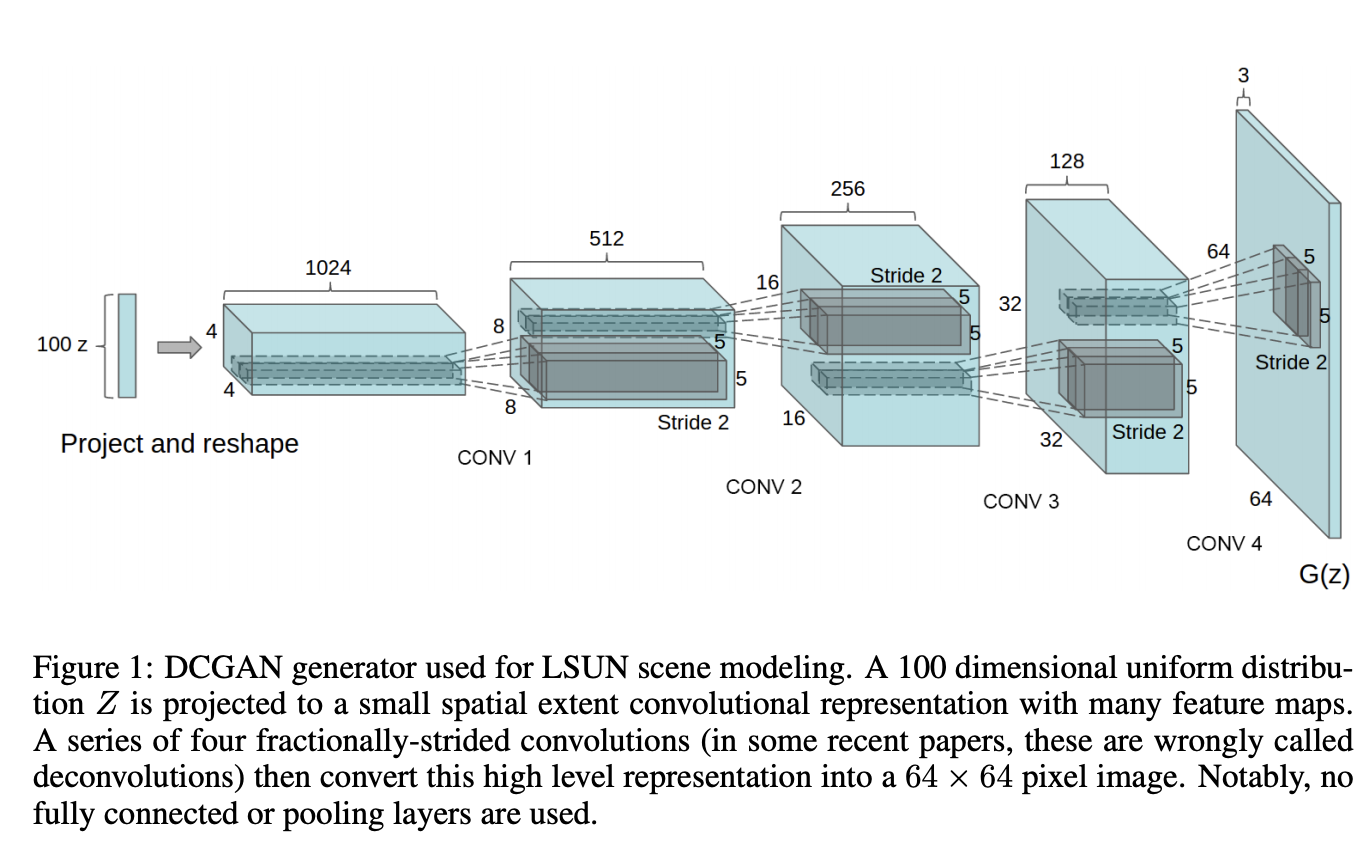



In [5]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [52]:

workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5


# Install Dataset


1.   upload kaggle.json file.
2.   download CelebFaces Attributes (CelebA) Dataset



In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
#Upload the token json file
from google.colab import files
files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                 title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/global-youtube-statistics-2023     Global YouTube Statistics 2023                  60KB  2023-07-28 15:36:38          12171        407  1.0              
nelgiriyewithana/top-spotify-songs-2023             Most Streamed Spotify Songs 2023                47KB  2023-08-26 11:04:57           1920         76  1.0              
iamsouravbanerjee/airline-dataset                   Airline Dataset                                  4MB  2023-08-30 12:03:12            795         26  1.0              
kacperrabczewski/every-porsche-911                  Every Porsche 911 since 1964                    21KB  2023-

In [2]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:13<00:00, 149MB/s]
100% 1.33G/1.33G [00:13<00:00, 109MB/s]


In [3]:
!unzip "celeba-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [6]:
dataset = dset.ImageFolder(root="/content/img_align_celeba",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

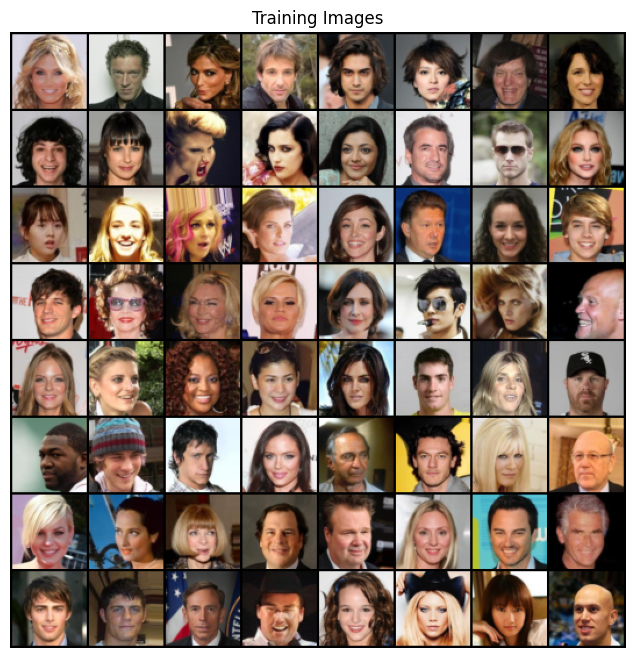

In [7]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# DCGAN generator and discriminator:

In [46]:
# Generator Code
class DCGAN_generator(nn.Module):
    def __init__(self):
        super(DCGAN_generator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(2 * ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

In [47]:
class DCGAN_discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [48]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [49]:
netG =DCGAN_generator().to(device)

netG.apply(weights_init)
# Print the model
print(netG)

DCGAN_generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): T

In [50]:
# Create the Discriminator
netD = DCGAN_discriminator().to(device)

netD.apply(weights_init)
# Print the model
print(netD)

DCGAN_discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [51]:
criterion = nn.BCELoss()
#z
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Train

In [53]:
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)

        errD_real = criterion(output, label)

        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)

        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)

        errD_fake = criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]tLoss_D: %.4ftLoss_G: %.4ftD(x): %.4ftD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

Starting Training Loop...
[0/5][0/1583]tLoss_D: 1.7599tLoss_G: 2.2369tD(x): 0.3330tD(G(z)): 0.2795 / 0.1450
[0/5][50/1583]tLoss_D: 0.4153tLoss_G: 7.6458tD(x): 0.8713tD(G(z)): 0.0661 / 0.0012
[0/5][100/1583]tLoss_D: 0.9439tLoss_G: 6.6972tD(x): 0.8482tD(G(z)): 0.4496 / 0.0036
[0/5][150/1583]tLoss_D: 1.3152tLoss_G: 5.4038tD(x): 0.7483tD(G(z)): 0.5270 / 0.0208
[0/5][200/1583]tLoss_D: 1.0368tLoss_G: 2.4528tD(x): 0.5879tD(G(z)): 0.2504 / 0.1323
[0/5][250/1583]tLoss_D: 0.6702tLoss_G: 3.1669tD(x): 0.7887tD(G(z)): 0.3118 / 0.0544
[0/5][300/1583]tLoss_D: 1.0348tLoss_G: 4.1835tD(x): 0.7969tD(G(z)): 0.4911 / 0.0252
[0/5][350/1583]tLoss_D: 1.1410tLoss_G: 1.4424tD(x): 0.4507tD(G(z)): 0.1298 / 0.2821
[0/5][400/1583]tLoss_D: 0.9652tLoss_G: 2.7036tD(x): 0.7083tD(G(z)): 0.3901 / 0.1078
[0/5][450/1583]tLoss_D: 1.0817tLoss_G: 1.7351tD(x): 0.5636tD(G(z)): 0.2840 / 0.2451
[0/5][500/1583]tLoss_D: 1.0274tLoss_G: 4.8059tD(x): 0.9126tD(G(z)): 0.5550 / 0.0157
[0/5][550/1583]tLoss_D: 0.6222tLoss_G: 3.6077tD(x): 0

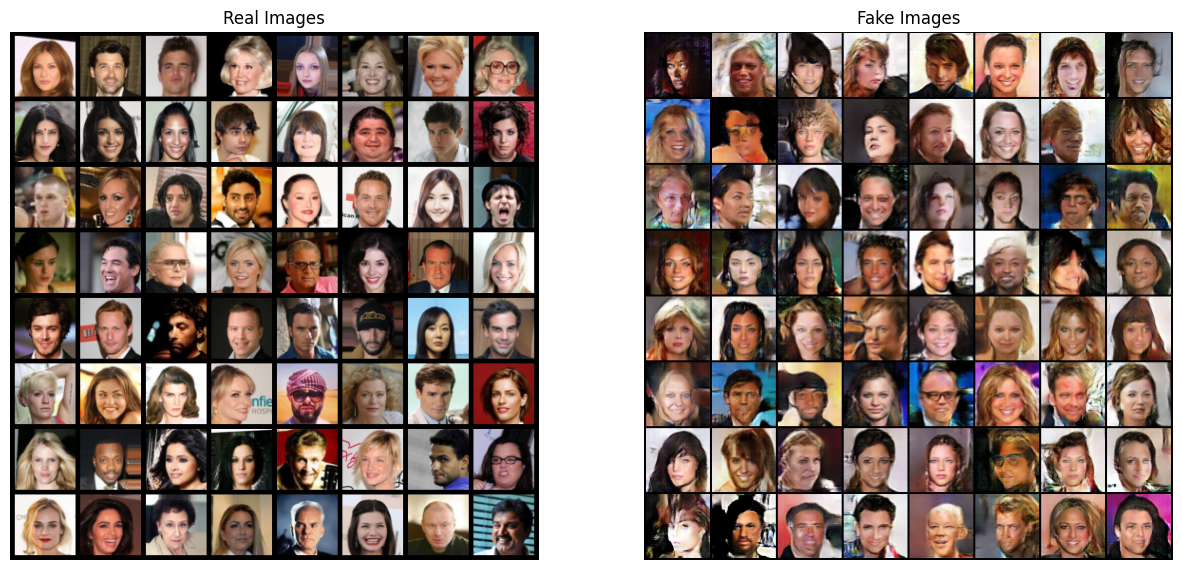

In [55]:
real_batch = next(iter(dataloader))

# Plot the real images

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)

plt.axis("off")

plt.title("Real Images")

plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[64:128], padding=5, normalize=True).cpu(),(1,2,0)))


# Plot the fake images from the last epoch

plt.subplot(1,2,2)

plt.axis("off")

plt.title("Fake Images")

plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.show()